In [ ]:
!pip install q keras==2.4.3

#%tensorflow_version 1.15.0


<img src="xray-header-image.png" style="padding-top: 50px;width: 87%;left: 0px;margin-left: 0px;margin-right: 0px;">


 We will explore medical image diagnosis by building a state-of-the-art chest X-ray classifier using Keras. 
In particular, we will:
- Pre-process and prepare a real-world X-ray dataset
- Use transfer learning to retrain a DenseNet model for X-ray image classification
- Learn a technique to handle class imbalance
- Measure diagnostic performance by computing the AUC (Area Under the Curve) for the ROC (Receiver Operating Characteristic) curve
- Visualize model activity using GradCAMs

 We will discuss in details about the following topics: 

- Data preparation
  - Visualizing data
  - Preventing data leakage
- Model Development
  - Addressing class imbalance
  - Leveraging pre-trained models using transfer learning
- Evaluation
  - AUC and ROC curves

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a name='1'></a>
## 1. Import Packages and Functions¶

We'll make use of the following packages:
- `numpy` and `pandas` is what we'll use to manipulate our data
- `matplotlib.pyplot` and `seaborn` will be used to produce plots for visualization
- `util` will provide the locally defined utility functions that have been provided for this assignment

We will also use several modules from the `keras` framework for building deep learning models.

Run the next cell to import all the necessary packages.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

import util


<a name='2'></a>
## 2 Load the Datasets

 We will be using the [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315) which contains 108,948 frontal-view X-ray images of 32,717 unique patients. 
- Each image in the data set contains multiple text-mined labels identifying 14 different pathological conditions. 
- These in turn can be used by physicians to diagnose 8 different diseases. 
- We will use this data to develop a single model that will provide binary classification predictions for each of the 14 labeled pathologies. 
- In other words it will predict 'positive' or 'negative' for each of the pathologies.
 
We can download the entire dataset for free [here](https://nihcc.app.box.com/v/ChestXray-NIHCC). 

- These can be accessed in the folder path stored in the `IMAGE_DIR` variable.

The dataset includes a CSV file that provides the labels for each X-ray. 

 

This dataset has been annotated by consensus among four different radiologists for 5 of our 14 pathologies:
- `Consolidation`
- `Edema`
- `Effusion`
- `Cardiomegaly`
- `Atelectasis`

In [ ]:
train_df = pd.read_csv("/content/drive/My Drive/Chest_X-Ray_Diagnosis-main/Codes and Pre-trained Model/preprocessed_dataset/train-small.csv")
valid_df = pd.read_csv("/content/drive/My Drive/Chest_X-Ray_Diagnosis-main/Codes and Pre-trained Model/preprocessed_dataset/valid-small.csv")

test_df = pd.read_csv("/content/drive/My Drive/Chest_X-Ray_Diagnosis-main/Codes and Pre-trained Model/preprocessed_dataset/test.csv")

In [ ]:

train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [ ]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']


<a name='2-1'></a>
### 2.1 Preventing Data Leakage
It is worth noting that our dataset contains multiple images for each patient. This could be the case, for example, when a patient has taken multiple X-ray images at different times during their hospital visits. In our data splitting, we have ensured that the split is done on the patient level so that there is no data "leakage" between the train, validation, and test datasets.

<a name='Ex-1'></a>
### Task 1 - Checking Data Leakage
In the cell below, write a function to check whether there is leakage between two datasets. We'll use this to make sure there are no patients in the test set that are also present in either the train or validation sets.

In [ ]:
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """

    
    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)
    
    patients_in_both_groups = list(df1_patients_unique.intersection(df2_patients_unique))

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len( patients_in_both_groups)>0 # boolean (true if there is at least 1 patient in both groups)
    

    
    return leakage

In [ ]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))


leakage between train and test: False
leakage between valid and test: False


<a name='2-2'></a>
### 2.2 Preparing Images

With our dataset splits ready, we can now proceed with setting up our model to consume them. 
- For this we will use the off-the-shelf [ImageDataGenerator](https://keras.io/preprocessing/image/) class from the Keras framework, which allows us to build a "generator" for images specified in a dataframe. 
- This class also provides support for basic data augmentation such as random horizontal flipping of images.
- We also use the generator to transform the values in each batch so that their mean is $0$ and their standard deviation is 1. 
    - This will facilitate model training by standardizing the input distribution. 
- The generator also converts our single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels.
    - We will want this because the pre-trained model that we'll use requires three-channel inputs.

Since it is mainly a matter of reading and understanding Keras documentation, we have implemented the generator for you. There are a few things to note: 
1. We normalize the mean and standard deviation of the data
3. We shuffle the input after each epoch.
4. We set the image size to be 320px by 320px

In [ ]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=16, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator


#### Build a separate generator for valid and test sets

Now we need to build a new generator for validation and testing data. 

** We use the same generator as for the training data**


- It normalizes each image **per batch**, meaning that it uses batch statistics. 
- We should not do this with the test and validation data, since in a real life scenario we don't process incoming images a batch at a time (we process one image at a time). 
- Knowing the average per batch of test data would effectively give our model an advantage.  
    - The model should not have any information about the test data.

What we need to do is normalize incoming test data using the statistics **computed from the training set**. 
* We implement this in the function below. 
* There is one technical note. Ideally, we would want to compute our sample mean and standard deviation using the entire training set. 
* However, since this is extremely large, that would be very time consuming. 
* In the interest of time, we'll take a random sample of the dataset and calcualte the sample mean and sample standard deviation.

In [ ]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=16, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    test_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    valid_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return test_generator, valid_generator

In [ ]:
IMAGE_DIR = "/content/drive/My Drive/Chest_X-Ray_Diagnosis-main/Codes and Pre-trained Model/preprocessed_dataset/images-small"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
test_generator, valid_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 1000 validated image filenames.
getting train and valid generators...
Found 1000 validated image filenames.
Found 200 validated image filenames.
Found 420 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


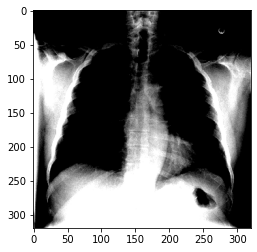

In [ ]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

<a name='3'></a>
## 3 Model Development

Now we'll move on to model training and development. We have a few practical challenges to deal with before actually training a neural network, though. The first is class imbalance.

<a name='3-1'></a>
### 3.1 Addressing Class Imbalance
One of the challenges with working with medical diagnostic datasets is the large class imbalance present in such datasets. Let's plot the frequency of each of the labels in our dataset:

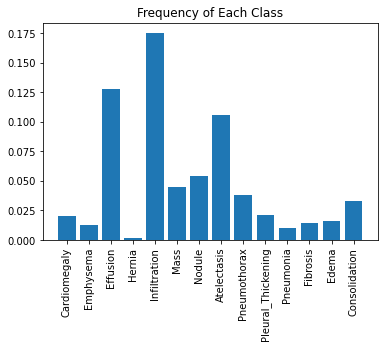

In [ ]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

We can see from this plot that the prevalance of positive cases varies significantly across the different pathologies. (These trends mirror the ones in the full dataset as well.) 
* The `Hernia` pathology has the greatest imbalance with the proportion of positive training cases being about 0.2%. 
* But even the `Infiltration` pathology, which has the least amount of imbalance, has only 17.5% of the training cases labelled positive.

Ideally, we would train our model using an evenly balanced dataset so that the positive and negative training cases would contribute equally to the loss. 

If we use a normal cross-entropy loss function with a highly unbalanced dataset, as we are seeing here, then the algorithm will be incentivized to prioritize the majority class (i.e negative in our case), since it contributes more to the loss. 

In [ ]:

def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
   
    
    # total number of patients (rows)
    N = len(labels)
    
    positive_frequencies = np.sum(labels,axis=0)/N
    negative_frequencies = 1-positive_frequencies

    
    return positive_frequencies, negative_frequencies

In [ ]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

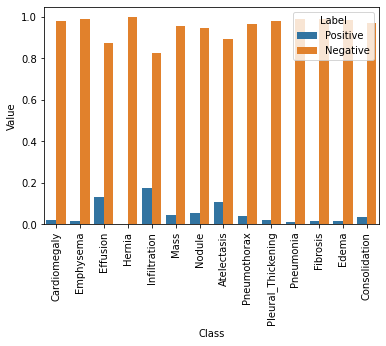

In [ ]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

As we see in the above plot, the contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same. 

To have this, we want 

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking 

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

In [ ]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

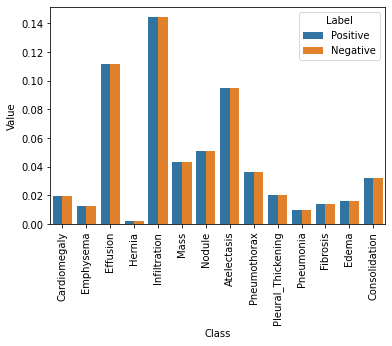

In [ ]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);



As the above figure shows, by applying these weightings the positive and negative labels within each class would have the same aggregate contribution to the loss function. Now let's implement such a loss function. 

After computing the weights, our final weighted loss for each training case will be 

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

<a name='Ex-3'></a>
### Task 3 - Weighted Loss
The `weighted_loss` function below returns a loss function that calculates the weighted loss for each batch. For the multi-class loss, we add up the average loss for each individual class. We also add a small value, $\epsilon$, to the predicted values before taking their logs. This is simply to avoid a numerical error that would otherwise occur if the predicted value happens to be zero.




In [ ]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
            -1 * np.sum(w_p[0] * 
                y_true[:, 0] * 
                np.log(y_pred[:, 0])
              )
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        y_true = K.cast(y_true, dtype='float32')
        y_pred = K.cast(y_pred, dtype='float32')

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += -1 * K.mean(pos_weights[i]*y_true[:,i]*K.log(y_pred[:,i]+epsilon)) + -1 * K.mean(neg_weights[i]*(1-y_true[:,i])*K.log(1-y_pred[:,i]+epsilon))  #complete this line
        return loss
    
    
    return weighted_loss

<a name='3-3'></a>
### 3.3 DenseNet121

Next, we will use a pre-trained [DenseNet121](https://www.kaggle.com/pytorch/densenet121) model which we can load directly from Keras and then add two layers on top of it:
1. A `GlobalAveragePooling2D` layer to get the average of the last convolution layers from DenseNet121.
2. A `Dense` layer with `sigmoid` activation to get the prediction logits for each of our classes.

We can set our custom loss function for the model by specifying the `loss` parameter in the `compile()` function.

In [ ]:
from keras.optimizers import SGD
from keras.metrics import *
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
]      

# create the base pre-trained model
base_model = DenseNet121(weights='/content/drive/My Drive/Chest_X-Ray_Diagnosis-main/Codes and Pre-trained Model/densenet.hdf5', include_top=False)

x =  base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)


# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

optimizer = SGD(learning_rate=0.001,momentum=0.9,nesterov=False)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=optimizer, loss=get_weighted_loss(pos_weights, neg_weights),metrics=METRICS)
  

In [ ]:

model.load_weights("/content/drive/My Drive/Chest_X-Ray_Diagnosis-main/Codes and Pre-trained Model/pretrained_model.h5")


<a name='5'></a>
## 5 Prediction and Evaluation

Now that we have a model, let's evaluate it using our test set. We can conveniently use the `predict_generator` function to generate the predictions for the images in our test set.



In [ ]:

predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))


Instructions for updating:
Please use Model.predict, which supports generators.


<a name='5-1'></a>
### 5.1 ROC Curve and AUROC


We will use the `util.get_roc_curve()` function which has been provided for you in `util.py`. Look through this function and note the use of the `sklearn` library functions to generate the ROC curves and AUROC values for our model. 



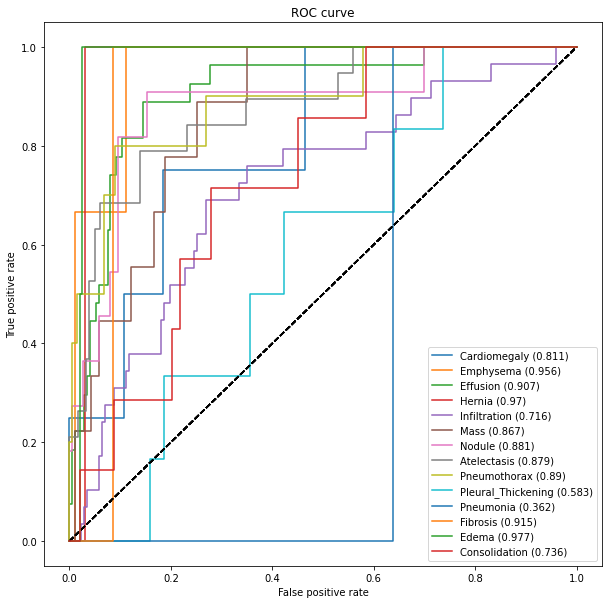

In [ ]:

auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)


<a name='5-2'></a>
### 5.2 Visualizing Learning with GradCAM 


One of the challenges of using deep learning in medicine is that the complex architecture used for neural networks makes them much harder to interpret compared to traditional machine learning models (e.g. linear models). 

One of the most common approaches aimed at increasing the interpretability of models for computer vision tasks is to use Class Activation Maps (CAM). 
- Class activation maps are useful for understanding where the model is "looking" when classifying an image. 

We will use a [GradCAM's](https://arxiv.org/abs/1610.02391) technique to produce a heatmap highlighting the important regions in the image for predicting the pathological condition. 
- This is done by extracting the gradients of each predicted class, flowing into our model's final convolutional layer. Look at the `util.compute_gradcam` which has been provided in `util.py` to see how this is done with the Keras framework. 

It is worth mentioning that GradCAM does not provide a full explanation of the reasoning for each classification probability. 
- However, it is still a useful tool for "debugging" our model and augmenting our prediction so that an expert could validate that a prediction is indeed due to the model focusing on the right regions of the image.

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Chest_X-Ray_Diagnosis-main/Codes and Pre-trained Model/preprocessed_dataset/train-small.csv")
IMAGE_DIR = "/content/drive/My Drive/Chest_X-Ray_Diagnosis-main/Codes and Pre-trained Model/preprocessed_dataset/images-small/"

# only show the labels with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

In [ ]:
#util.compute_gradcam(model,"00008270_015.png", IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Emphysema
Generating gradcam for class Nodule
Generating gradcam for class Pleural_Thickening
Generating gradcam for class Pneumonia


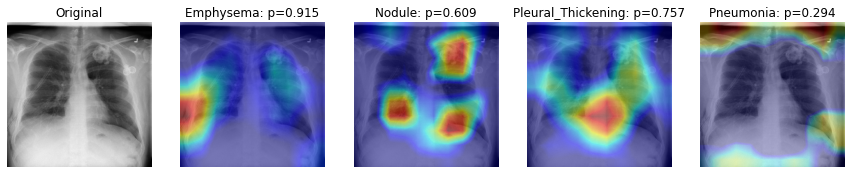

In [ ]:
util.compute_gradcam(model, '00011355_002.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Emphysema
Generating gradcam for class Nodule
Generating gradcam for class Pleural_Thickening
Generating gradcam for class Pneumonia


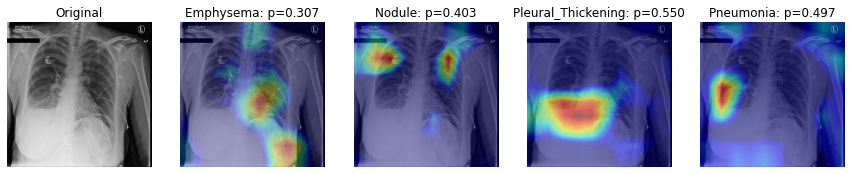

In [ ]:
util.compute_gradcam(model, '00029855_001.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Emphysema
Generating gradcam for class Nodule
Generating gradcam for class Pleural_Thickening
Generating gradcam for class Pneumonia


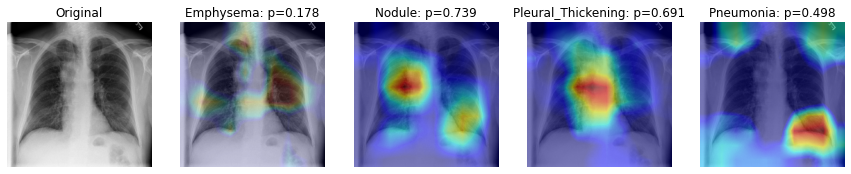

In [ ]:
util.compute_gradcam(model, '00005410_000.png', IMAGE_DIR, df, labels, labels_to_show)